# Topic: Dynamic Mode Decomposition
Author: Tysum Ruchti, truchti@byu.edu

## Introduction

Dynamic Mode Decomposition is a method of approximating a high dimensional and non-linear system through linear approximation and dimension reduction. This methods expands on the Singular Value Decomposition to approximate the eigen values and eigenvectors of a linear operator $A$ that best maps the data from $X[k]$ to $X[k+1]$. That is to find $X[k+1] = AX[k]$. The idea is to represent the complex behavior as spatial patterns that can decay grow or maintain magnitude as they oscillate in time.


## Variables
First let me describe the symbols I will use:
 
$m$ is the number of spatial dimensions
 
$n$ is the number of temporal dimensions
 
$X$ is all spatial dimensions of the data in a column for time 1 time step 1 to n-1, (size: m $\times$ n-1)

$X'$ is similar to $X$ but for time steps 2 to n, (size: m $\times$ n-1)

$A$ is the linear operator that best maps X to X' (size: m $\times$ m)

## The Algorithm Theory

We are looking to solve for our operator $A$, we can do this directly by computing $ A = X'X^{\dagger}$, where $X^{\dagger}$ is the pseudo-inverse of X. 
This, however becomes vastly more time consuming when we have huge number of spatial dimensions to our problem since the size of $A$ is $m \times m$

Instead we will calculate the dominate eigenvectors of $A$ and their associated eigenvalues without calculating $A$ itself.
This starts with the SVD of X
$$ X = U\Sigma V^H$$
We now have 
$$ X' = AU\Sigma V{H}$$

We can rearrange the equation to become 
$$ U^{H} X' V \Sigma^{-1} = U^{H}AU = \tilde{A}$$
and define the term $\tilde{A}$

We can then solve for the eigen decomposition of $\tilde{A}$ such that 
$$\tilde{A}W = W\Lambda $$
The eigenvalues of $A$ are equal to the eigen values of $\tilde{A}$, while the eigenvectors of $\tilde{A}$ are related to the eigenvectors of $A$ by
$$ \Phi = X'V \Sigma^{-1}W $$
Where $\Phi$ contains the eigen vectors of $A$ and $\Phi^{\dagger}$ represents the Moore-Penrose pseudoinverse of $\Phi$

A complete model can now be built given an initial condition $x_{0}$ and the interval between the time steps ${\Delta T}$
$$\Omega = \frac{\ln{\Lambda}}{\Delta T}$$ 
$$ b = \Phi^{\dagger}x_1$$
$$X(t) = \Phi \exp(\Omega t)b$$

Additionally, we can look at the stability of each mode in the model by looking at its associated eigenvalue.  
If $|\lambda_{p}| < 1$ the mode shape decays through time.

If $|\lambda_{p}| = 1$ the mode shape will oscillate indefinitely. 

If  $|\lambda_{p}| > 1$ the mode will grow infinitely. 


## Application 
The best way see how the algorithm works is to see example. So now that the maths have been presented I will work through application the DMD algorithm to a data set regarding vorticity in a fluid field published by Nathan Kutz et al. in their book Dynamic Mode Decomposition: Data-Driven modeling of complex systems.

This data has 89351 spatial dimensions, which isn't all that many. if we were to calculate A directly it would take 60 GB of memory just to store A


The code below loads in the data, creates X and X', and shows an image of what one time step's spatial dimensions look like

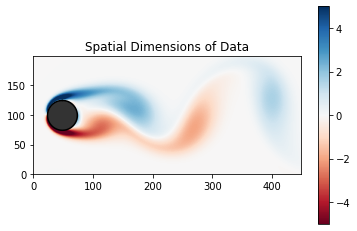

In [381]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

file = sio.loadmat('Example_data.mat')
data = file['data']
nt = np.int(file['nt'])
nx = np.int(file['nx'])
ny = np.int(file['ny'])
X = data[:,0:nt-1]
XP = data[:,1:nt]
vort = data[:,1]
ax = plot_vorticity(vort,nx,ny, "Spatial Dimensions of Data" )

We now compute the SVD of $X$ and calculate $\tilde{A}$

In [382]:
(U, s, Vh) = np.linalg.svd(X, full_matrices=False)

To further reduce the time necessary in the analysis we can also truncate the number of Singluar values we keep. In this case I will keep all singular values greater than a $\sigma_{1}\times 10^{-3.1}$ These values will be stored as $U_r$, $V_r$ and $S_r$

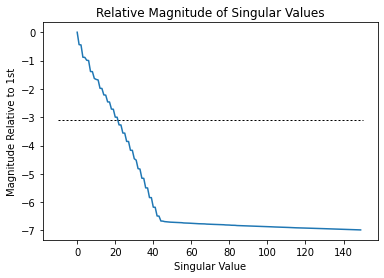

In [383]:
truncate_mag = -3.1
ax = plot_singular_value_relative_magnitudes(s, truncate_mag)
#takes all singular values above truncated magnitude and associated columns of U and V
(U_r, S_r, V_r) = truncate_SVD(U, s, Vh, truncate_mag) 


We now calculate $\tilde{A}$ and its eigen decomposition $\tilde{A}W = W\Lambda$. Where $W$ is the matrix of eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues

In [384]:
A_tilde = U_r.transpose()@ XP @ V_r @ np.linalg.inv(S_r)
(D,W) = np.linalg.eig(A_tilde)
(D,W) = sort_eigenvalues(D, W) #sort the eigenvalues
Lambda = np.diag(D)

We can now calculate the dominate eigenvectors of $A$ from our eigenvectors of $\tilde{A}$ as follows. Note that this will only give use the first r eigenvectors of A where r is the number of singular values we used in the truncation.
The code belows provides visiualization of the mode specified.

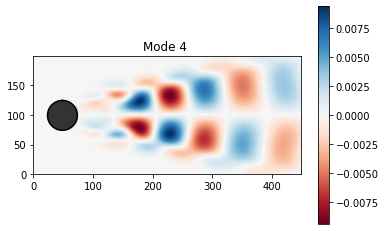

In [385]:
Phi = XP@V_r@np.linalg.inv(S_r)@W
# mode 0 is the steady state mode (no imaginary portion)
# mode 15 a non-oscillating damped mode (no imaginary magnitude < 1)
# The remaining modes come in complex pairs (e.g. mode 2 and 3 are the same shape)
mode = 4
string =  "Mode %d " % (mode)
ax = plot_vorticity(Phi[:,mode], nx, ny, string)


We can also look at the how the mode changes with time by ploting the magnitudes of our eigenvalues on a real/imaginary axis with the unit circle. 
If $|\lambda_{m}| < 1$ the mode is damped and the magnitude decays with time
If $|\lambda_{m}| = 1$ the mode magnitude is constant though the mode may oscillate
If $|\lambda_{m}| > 1$ the mode grows with time

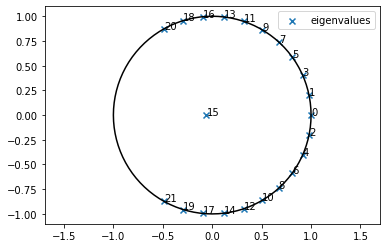

In [386]:
ax = plot_eigenvalues(D)

We can see here that mode 15 is damped while the rest of the modes are constant magnitude through time


Now that we have our decomposition lets compare the last time step of our vorticity data to what our model would predicted based solely on the initial conditions. 

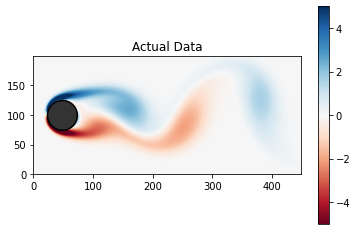

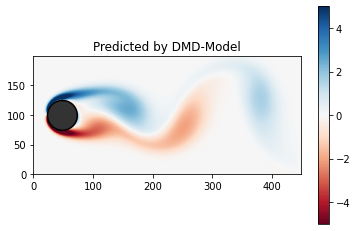

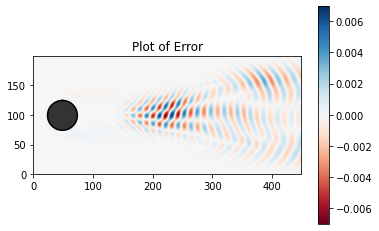

In [387]:
b = np.linalg.pinv(Phi)@X[:,0]
dt = 1; # one unit of time
omega = np.log(D)/dt # vector form of omega

#for i in range(nt): # this loop allows you to calculate a prediction for every time step
#    Xpredict(:,i) = real(Phi*(diag(exp(omega*(i)))*b)); 
timeOfInterest = 150
calculate = np.real(Phi@(np.diag(np.exp(omega*timeOfInterest*dt)))@b)
compare = data[:,-1] #last frame of data
ax = plot_vorticity(compare,nx,ny, "Actual Data")
ax = plot_vorticity(calculate,nx,ny, "Predicted by DMD-Model")

error = plot_vorticity(compare-calculate, nx,ny, "Plot of Error")


Note that the magnitude of the error is relatively small. It also appears that the error structure is similar in shape to the higher modes we calculated. This error can be reduced by including more modes in the calculation. This is done by truncating less. 

## Conclusion
In the example above we were able to approximate $A (89351 \times 89351)$ with a subset of eigenvectors of A where the size of $\Phi$ is $89351 \times 22$, while still maintaining the dynamic properties of our subsystem. While first developed to work with fluids this method is currently being used to analyze everything from brain scans to epidemic spreading of disease.

## Functions

In [388]:
def truncate_SVD(U, s, Vh, trunc_mag):
    normed_s = np.log10(s/s[0])
    s_r = s[normed_s>truncate_mag]
    n = len(s_r);
    U_r = U[:,0:n]
    S_r = np.diag(s_r)
    Vh_r = Vh[0:n, :]
    V_r = Vh_r.transpose()
    return U_r, S_r, V_r

def sort_eigenvalues(D,W):
    sortindex = D.argsort()[::-1] 
    D = D[sortindex]
    W = W[:, sortindex]
    return D,W

def plot_vorticity(vort, nx, ny, titles = ""):
    vmax = 5;
    vmin = -vmax;
    vort[vort>vmax] = vmax
    vort[vort<vmin] = vmin
    fig, axs = plt.subplots(ncols=1, nrows=1)  # 1 row, 1 columns
    vort = np.reshape (vort, (nx,ny), order='F')
    axs = scaledimage(vort, 1, axs, titles)
    plot_cyl()
    return axs
    
def plot_eigenvalues(Lambda_vector):
    fig, axs = plt.subplots(ncols=1, nrows=1)
    
    xs = np.real(Lambda_vector)
    ys = np.imag(Lambda_vector)
    eigens = axs.scatter(xs,ys, marker ="x", label = "eigenvalues")
    numbers = np.arange(len(Lambda_vector))
    for i, txt in enumerate(numbers):
        axs.annotate(txt, (xs[i], ys[i]))
    plt.legend(handles=[eigens])
    plot_unit_circle(axs)
    return axs
        
def plot_singular_value_relative_magnitudes(s, truncate_mag = 0):
    normed_s = np.log10(s/s[0])
    fig, axs = plt.subplots(ncols=1, nrows=1)
    axs.plot(normed_s);
    plt.xlabel('Singular Value');
    plt.ylabel('Magnitude Relative to 1st');
    if truncate_mag != 0:
        axs.plot([-10, 150], [truncate_mag, truncate_mag], 'k-', lw=1,dashes=[2, 2]);
        
    plt.title("Relative Magnitude of Singular Values")
    return axs

def scaledimage(W, pixwidth=1, ax=None, plot_title = ""):
    (N, M) = W.shape 
    plotW = np.real(W)
    # Need to create a new Axes?
    if(ax == None):
        ax = plt.figure().gca()
    # extents = Left Right Bottom Top
    exts = (0, pixwidth * M, 0, pixwidth * N)
    cs = ax.imshow(plotW,
              interpolation='bilinear',
              cmap = plt.get_cmap('RdBu'),
              extent=exts)
    plt.colorbar(cs)
    plt.title(plot_title)
    return ax

def plot_cyl():
    theta = (np.arange(101.0))/100.0*2.0*3.1415926;
    x = 49+25*np.sin(theta);
    y = 99+25*np.cos(theta);
    plt.fill(x,y,'0.2')  # place cylinder
    plt.plot(x,y,'k')
    
def plot_unit_circle(axs):
    theta = (np.arange(101.0))/100.0*2.0*3.1415926;
    x = np.sin(theta);
    y = np.cos(theta);
    axs.plot(x,y,'k')
    axs.axis('equal')